# Exploring `cactice`

This notebook demonstrates basic `cactice` usage and explores some use cases.

## Reading data into `cactice`

First we review the formats `cactice` supports and demonstrate how to read some sample data. `cactice` currently supports 2 formats:

- comma- or tab-delimited data (CSV/TSV)
- text grids (2D character arrays)

### CSV files

`cactice` can read 1 or more grids from a CSV or TSV file containing columns for:

- grid index
- class label
- row index
- column index

By default `cactice` expects to find columns named `Grid`, `Class`, `I`, and `J`, respectively. Alternative mappings can also be provided. Note that the file *must* begin with a header row.

For instance, to read in some sample grids from a CSV file:

In [1]:
from typing import Dict
import numpy as np
from cactice.fileio import read_grids_csv

grids: Dict[str, np.ndarray] = read_grids_csv('../testdata/grids.csv')

### Text files

`cactice` can also read a single grid from a text file. The text is interpreted as a 2-dimensional character array, with newlines delimiting rows and each distinct character a class.

For instance:

In [2]:
from cactice.fileio import read_grid_txt

grids['from_text'] = read_grid_txt('../testdata/grid.txt')

## Plotting grids

Now that we've loaded some grids into `cactice` we can take a look at them.

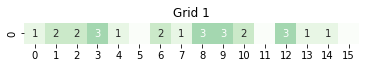

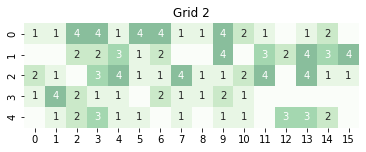

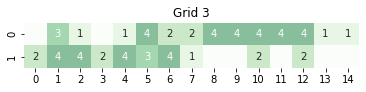

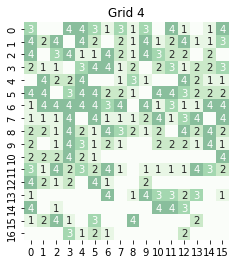

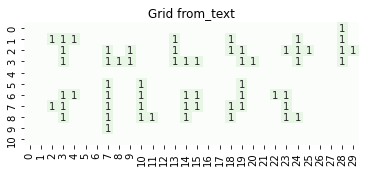

In [3]:
from cactice.plot import plot_grid

for name, grid in grids.items():
    plot_grid(grid, f"Grid {name}")

## Computing summary statistics

### Cell distribution

Now we'll calculate the grid cell class distribution overall and on a per-grid basis.

Overall cell distribution:
{0: 0.52473, 1: 0.21016, 2: 0.0989, 3: 0.05495, 4: 0.11126}


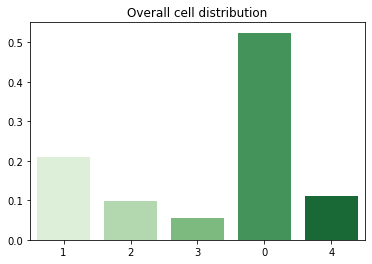

Grid 1 cell distribution:
{0: 0.1875, 1: 0.3125, 2: 0.25, 3: 0.25}


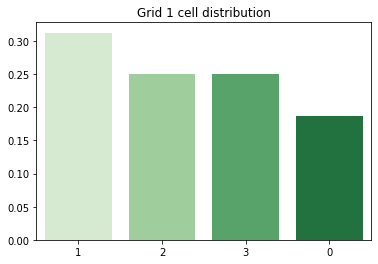

Grid 2 cell distribution:
{0: 0.25, 1: 0.3375, 2: 0.1625, 3: 0.0875, 4: 0.1625}


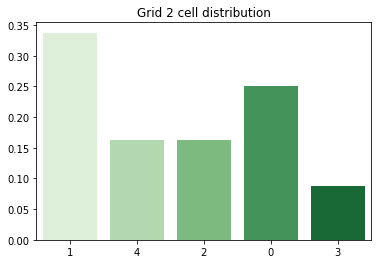

Grid 3 cell distribution:
{0: 0.23333, 1: 0.16667, 2: 0.2, 3: 0.06667, 4: 0.33333}


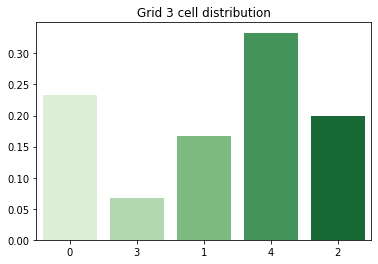

Grid 4 cell distribution:
{0: 0.30147, 1: 0.20588, 2: 0.18015, 3: 0.09926, 4: 0.21324}


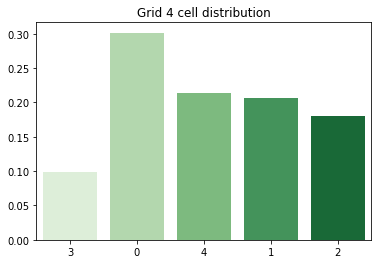

Grid from_text cell distribution:
{0: 0.82, 1: 0.18}


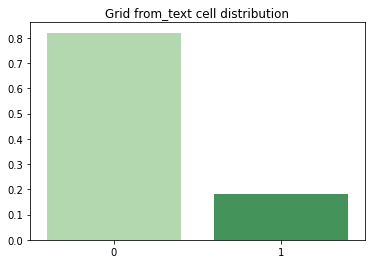

In [4]:
from pprint import pprint
import cactice.stats as stats
from cactice.plot import plot_cell_dist

grids_l = list(grids.values())
cell_dist = stats.cell_dist(grids_l)

title = "Overall cell distribution"
print(f"{title}:")
pprint(cell_dist)
plot_cell_dist(cell_dist, title)

for name, grid in grids.items():
    title = f"Grid {name} cell distribution"
    print(f"{title}:")
    grid_cell_dist = stats.cell_dist([grid])
    pprint(grid_cell_dist)
    plot_cell_dist(grid_cell_dist, title)

### Bond distribution

We can also take a look at the distribution of bonds (adjacencies) between grid cell classes.

Overall undirected bonds (horizontal):
{(0, 0): 0.376377952755906,
 (0, 1): 0.165354330708661,
 (0, 2): 0.058267716535433,
 (0, 3): 0.022047244094488,
 (0, 4): 0.056692913385827,
 (1, 1): 0.069291338582677,
 (1, 2): 0.045669291338583,
 (1, 3): 0.026771653543307,
 (1, 4): 0.050393700787402,
 (2, 2): 0.015748031496063,
 (2, 3): 0.023622047244094,
 (2, 4): 0.036220472440945,
 (3, 3): 0.0,
 (3, 4): 0.025196850393701,
 (4, 4): 0.028346456692913}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


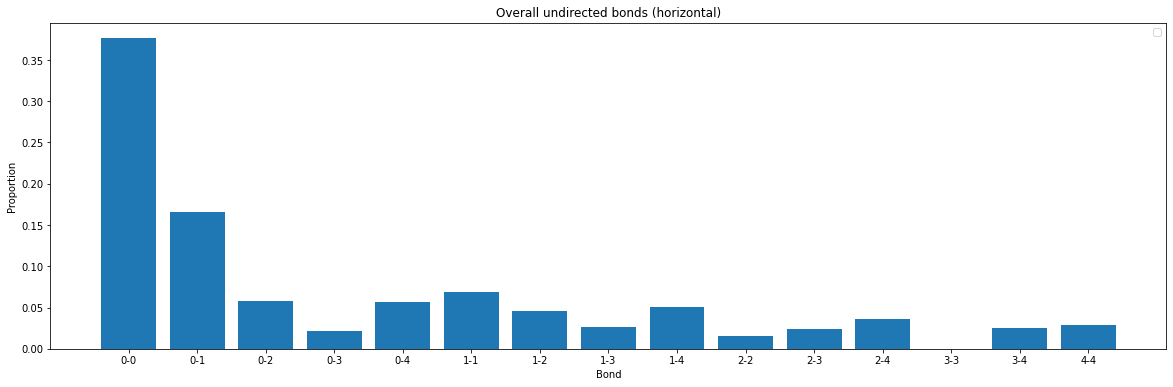

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Overall undirected bonds (vertical):
{(0, 0): 0.390173410404624,
 (0, 1): 0.167630057803468,
 (0, 2): 0.040462427745665,
 (0, 3): 0.021676300578035,
 (0, 4): 0.041907514450867,
 (1, 1): 0.060693641618497,
 (1, 2): 0.049132947976879,
 (1, 3): 0.028901734104046,
 (1, 4): 0.05635838150289,
 (2, 2): 0.020231213872832,
 (2, 3): 0.023121387283237,
 (2, 4): 0.041907514450867,
 (3, 3): 0.004335260115607,
 (3, 4): 0.027456647398844,
 (4, 4): 0.026011560693642}


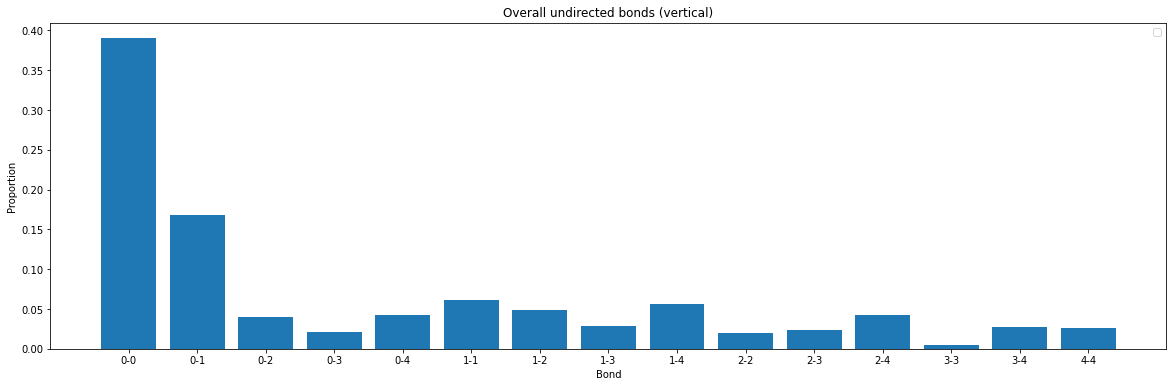

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Overall undirected bonds (combined):
{(0, 0): 0.390173410404624,
 (0, 1): 0.167630057803468,
 (0, 2): 0.040462427745665,
 (0, 3): 0.021676300578035,
 (0, 4): 0.041907514450867,
 (1, 1): 0.060693641618497,
 (1, 2): 0.049132947976879,
 (1, 3): 0.028901734104046,
 (1, 4): 0.05635838150289,
 (2, 2): 0.020231213872832,
 (2, 3): 0.023121387283237,
 (2, 4): 0.041907514450867,
 (3, 3): 0.004335260115607,
 (3, 4): 0.027456647398844,
 (4, 4): 0.026011560693642}


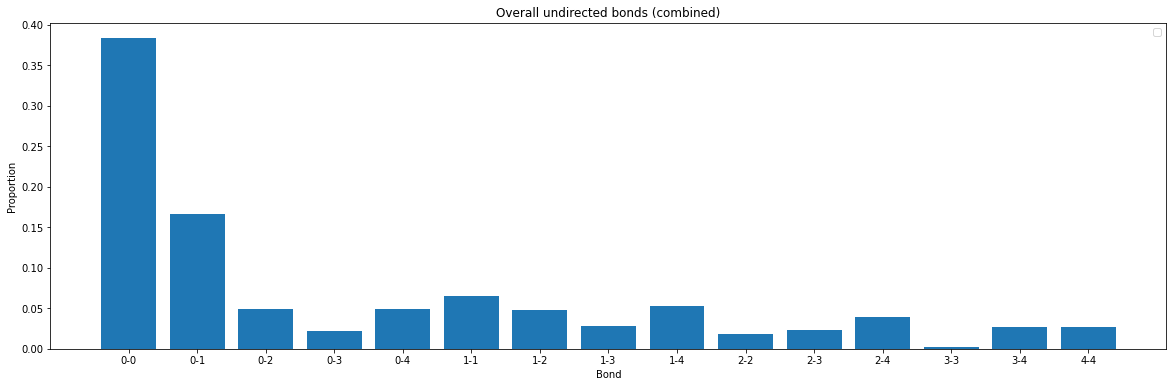

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '1' undirected bonds (horizontal):
{(0, 0): 0,
 (0, 1): 0,
 (0, 2): 0,
 (0, 3): 0,
 (1, 1): 0,
 (1, 2): 0,
 (1, 3): 0,
 (2, 2): 0,
 (2, 3): 0,
 (3, 3): 0}


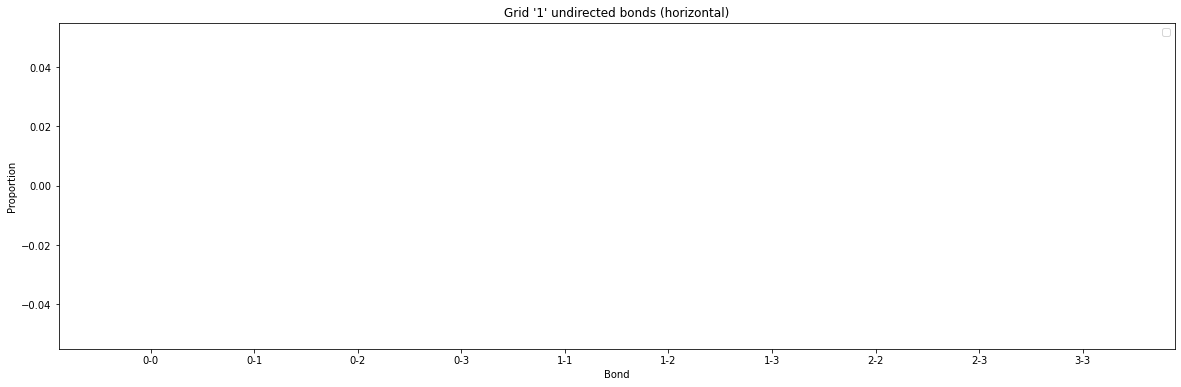

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '1' undirected bonds (vertical):
{(0, 0): 0.0,
 (0, 1): 0.1333333333,
 (0, 2): 0.1333333333,
 (0, 3): 0.0666666667,
 (1, 1): 0.0666666667,
 (1, 2): 0.1333333333,
 (1, 3): 0.2,
 (2, 2): 0.0666666667,
 (2, 3): 0.1333333333,
 (3, 3): 0.0666666667}


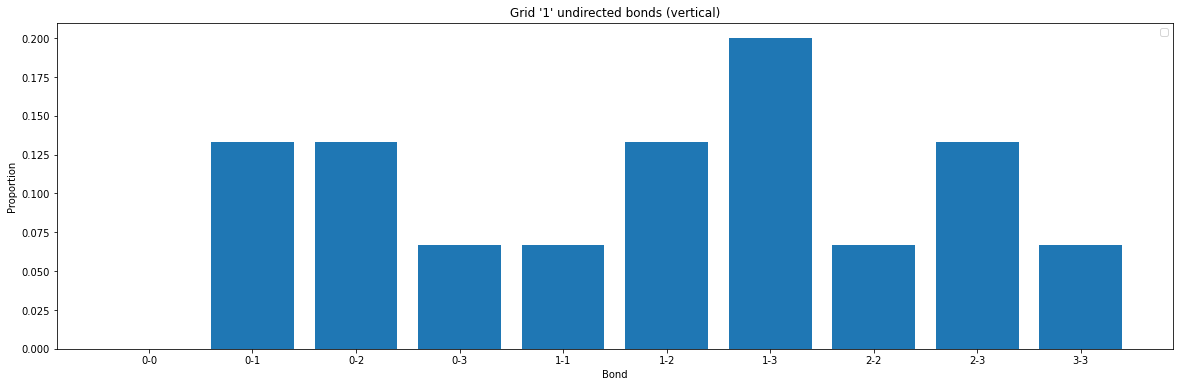

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '1' undirected bonds (combined):
{(0, 0): 0.0,
 (0, 1): 0.1333333333,
 (0, 2): 0.1333333333,
 (0, 3): 0.0666666667,
 (1, 1): 0.0666666667,
 (1, 2): 0.1333333333,
 (1, 3): 0.2,
 (2, 2): 0.0666666667,
 (2, 3): 0.1333333333,
 (3, 3): 0.0666666667}


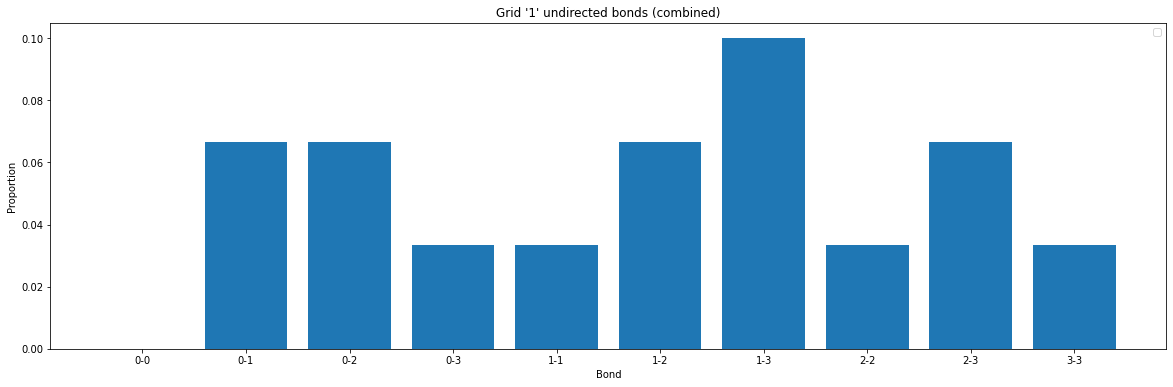

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '2' undirected bonds (horizontal):
{(0, 0): 0.046875,
 (0, 1): 0.1875,
 (0, 2): 0.140625,
 (0, 3): 0.03125,
 (0, 4): 0.0625,
 (1, 1): 0.078125,
 (1, 2): 0.09375,
 (1, 3): 0.078125,
 (1, 4): 0.125,
 (2, 2): 0.015625,
 (2, 3): 0.03125,
 (2, 4): 0.046875,
 (3, 3): 0.0,
 (3, 4): 0.03125,
 (4, 4): 0.03125}


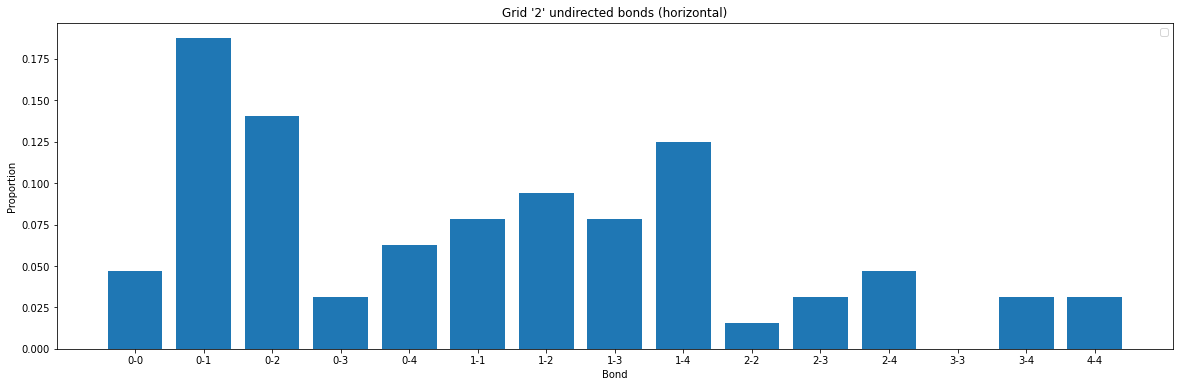

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '2' undirected bonds (vertical):
{(0, 0): 0.08,
 (0, 1): 0.146666666666667,
 (0, 2): 0.066666666666667,
 (0, 3): 0.04,
 (0, 4): 0.053333333333333,
 (1, 1): 0.12,
 (1, 2): 0.133333333333333,
 (1, 3): 0.026666666666667,
 (1, 4): 0.133333333333333,
 (2, 2): 0.013333333333333,
 (2, 3): 0.053333333333333,
 (2, 4): 0.053333333333333,
 (3, 3): 0.013333333333333,
 (3, 4): 0.04,
 (4, 4): 0.026666666666667}


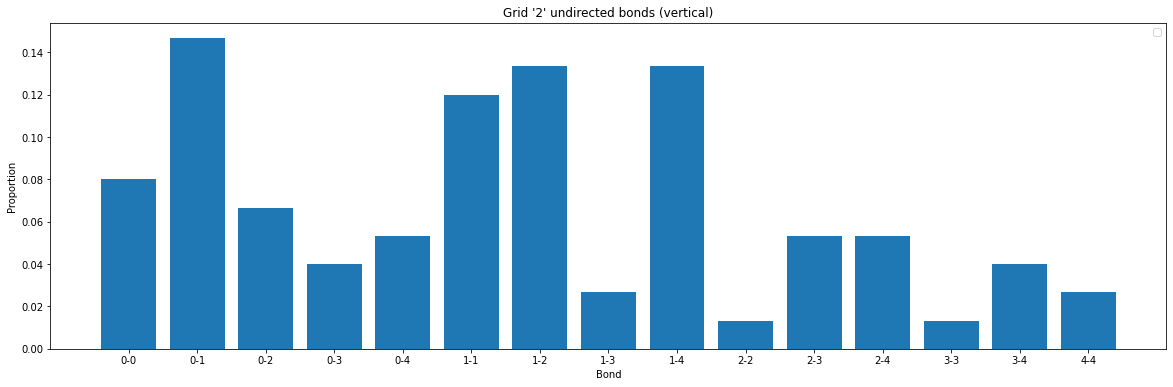

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '2' undirected bonds (combined):
{(0, 0): 0.08,
 (0, 1): 0.146666666666667,
 (0, 2): 0.066666666666667,
 (0, 3): 0.04,
 (0, 4): 0.053333333333333,
 (1, 1): 0.12,
 (1, 2): 0.133333333333333,
 (1, 3): 0.026666666666667,
 (1, 4): 0.133333333333333,
 (2, 2): 0.013333333333333,
 (2, 3): 0.053333333333333,
 (2, 4): 0.053333333333333,
 (3, 3): 0.013333333333333,
 (3, 4): 0.04,
 (4, 4): 0.026666666666667}


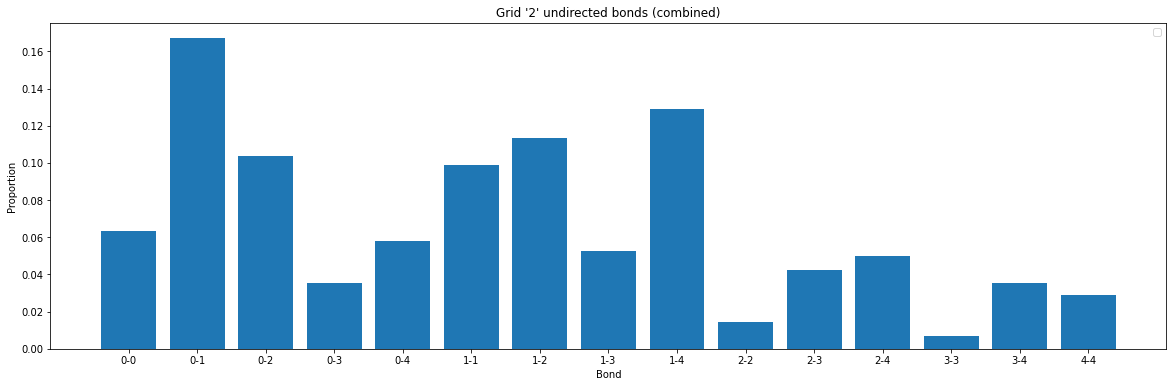

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '3' undirected bonds (horizontal):
{(0, 0): 0.0,
 (0, 1): 0.133333333333333,
 (0, 2): 0.133333333333333,
 (0, 3): 0.0,
 (0, 4): 0.2,
 (1, 1): 0.0,
 (1, 2): 0.066666666666667,
 (1, 3): 0.0,
 (1, 4): 0.133333333333333,
 (2, 2): 0.0,
 (2, 3): 0.0,
 (2, 4): 0.2,
 (3, 3): 0.0,
 (3, 4): 0.133333333333333,
 (4, 4): 0.0}


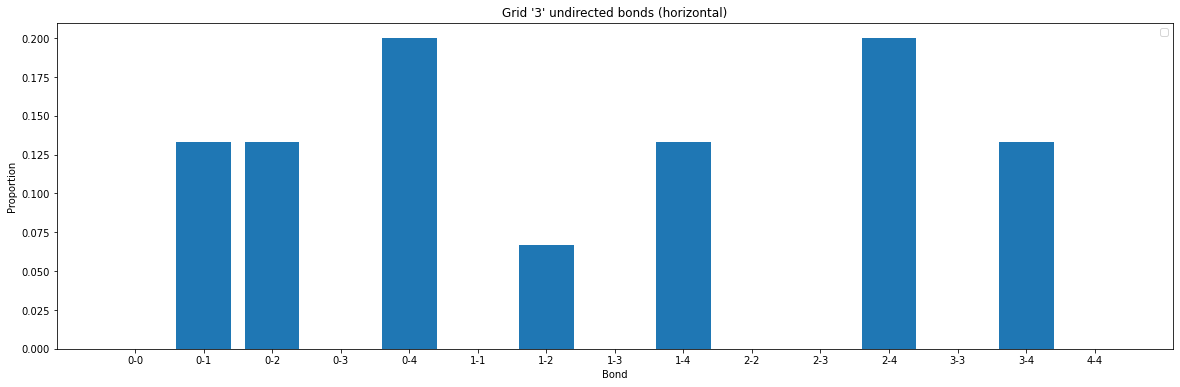

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '3' undirected bonds (vertical):
{(0, 0): 0.071428571428571,
 (0, 1): 0.107142857142857,
 (0, 2): 0.142857142857143,
 (0, 3): 0.035714285714286,
 (0, 4): 0.0,
 (1, 1): 0.035714285714286,
 (1, 2): 0.0,
 (1, 3): 0.035714285714286,
 (1, 4): 0.107142857142857,
 (2, 2): 0.035714285714286,
 (2, 3): 0.0,
 (2, 4): 0.178571428571429,
 (3, 3): 0.0,
 (3, 4): 0.071428571428571,
 (4, 4): 0.178571428571429}


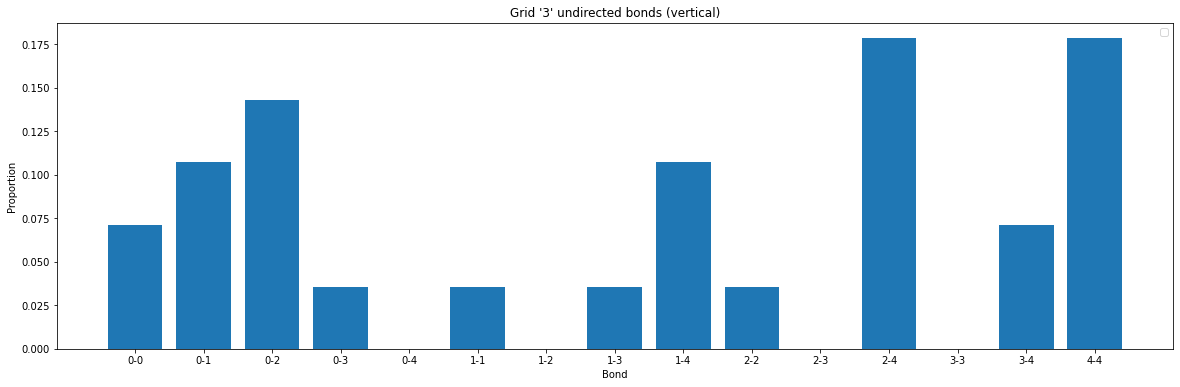

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '3' undirected bonds (combined):
{(0, 0): 0.071428571428571,
 (0, 1): 0.107142857142857,
 (0, 2): 0.142857142857143,
 (0, 3): 0.035714285714286,
 (0, 4): 0.0,
 (1, 1): 0.035714285714286,
 (1, 2): 0.0,
 (1, 3): 0.035714285714286,
 (1, 4): 0.107142857142857,
 (2, 2): 0.035714285714286,
 (2, 3): 0.0,
 (2, 4): 0.178571428571429,
 (3, 3): 0.0,
 (3, 4): 0.071428571428571,
 (4, 4): 0.178571428571429}


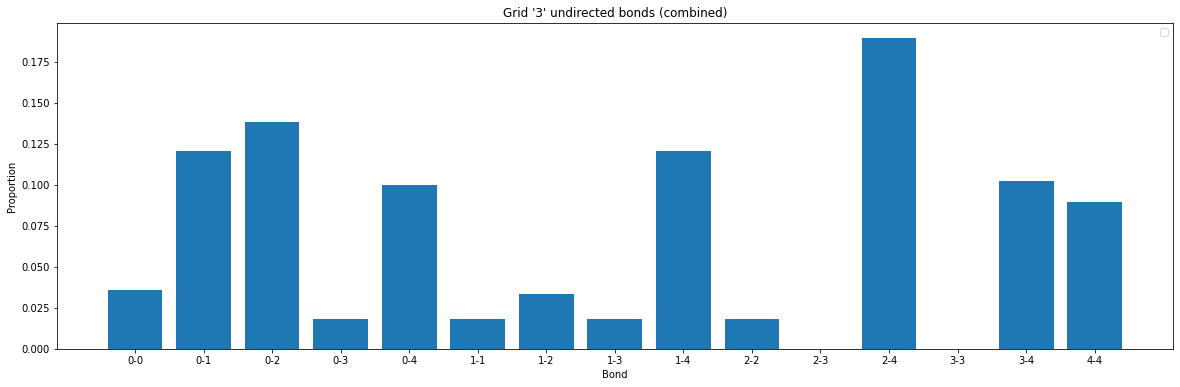

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '4' undirected bonds (horizontal):
{(0, 0): 0.09765625,
 (0, 1): 0.125,
 (0, 2): 0.1015625,
 (0, 3): 0.046875,
 (0, 4): 0.11328125,
 (1, 1): 0.03515625,
 (1, 2): 0.0859375,
 (1, 3): 0.046875,
 (1, 4): 0.0859375,
 (2, 2): 0.03515625,
 (2, 3): 0.05078125,
 (2, 4): 0.06640625,
 (3, 3): 0.0,
 (3, 4): 0.046875,
 (4, 4): 0.0625}


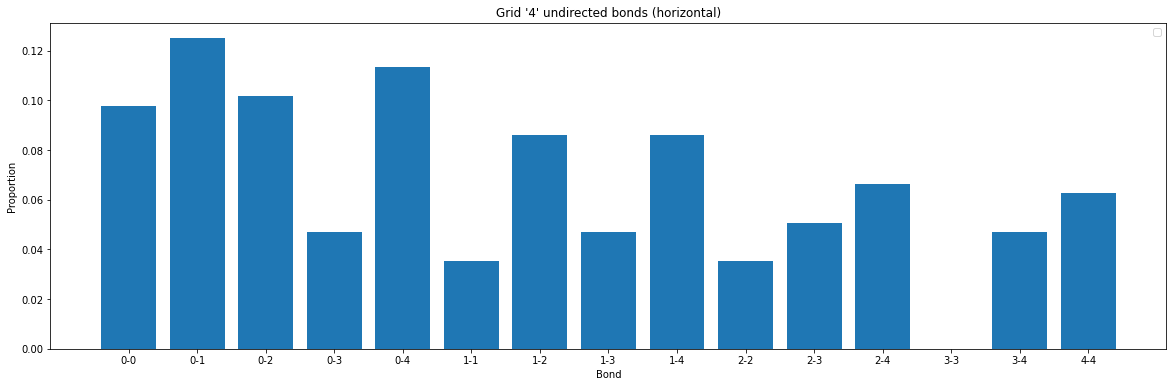

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '4' undirected bonds (vertical):
{(0, 0): 0.168627450980392,
 (0, 1): 0.074509803921569,
 (0, 2): 0.066666666666667,
 (0, 3): 0.03921568627451,
 (0, 4): 0.098039215686275,
 (1, 1): 0.047058823529412,
 (1, 2): 0.086274509803922,
 (1, 3): 0.054901960784314,
 (1, 4): 0.101960784313725,
 (2, 2): 0.043137254901961,
 (2, 3): 0.03921568627451,
 (2, 4): 0.07843137254902,
 (3, 3): 0.003921568627451,
 (3, 4): 0.054901960784314,
 (4, 4): 0.043137254901961}


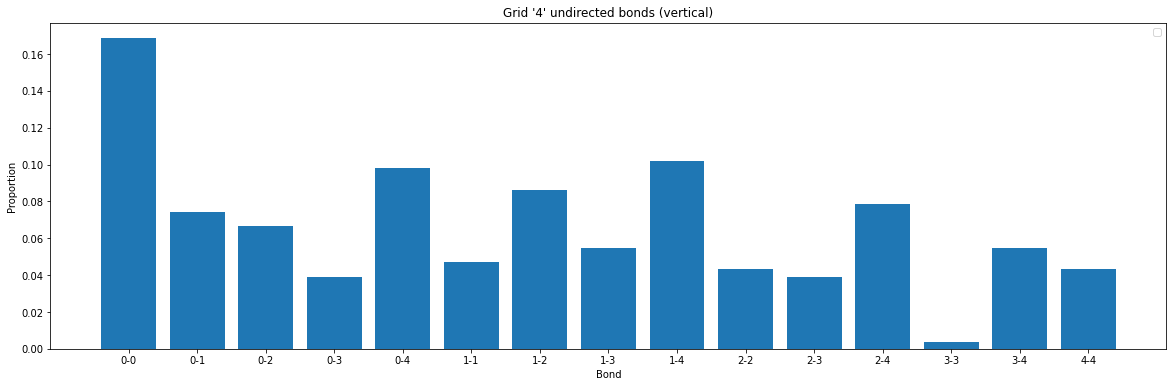

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid '4' undirected bonds (combined):
{(0, 0): 0.168627450980392,
 (0, 1): 0.074509803921569,
 (0, 2): 0.066666666666667,
 (0, 3): 0.03921568627451,
 (0, 4): 0.098039215686275,
 (1, 1): 0.047058823529412,
 (1, 2): 0.086274509803922,
 (1, 3): 0.054901960784314,
 (1, 4): 0.101960784313725,
 (2, 2): 0.043137254901961,
 (2, 3): 0.03921568627451,
 (2, 4): 0.07843137254902,
 (3, 3): 0.003921568627451,
 (3, 4): 0.054901960784314,
 (4, 4): 0.043137254901961}


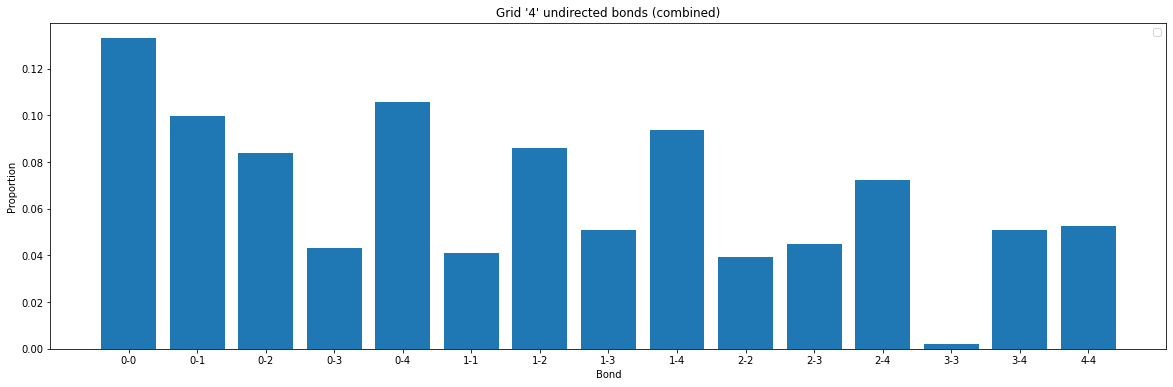

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid 'from_text' undirected bonds (horizontal):
{(0, 0): 0.703, (0, 1): 0.197, (1, 1): 0.1}


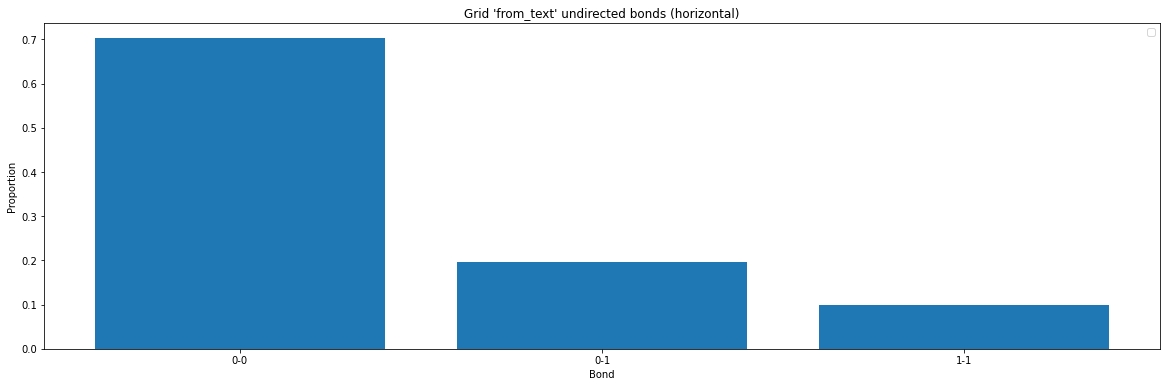

Grid 'from_text' undirected bonds (vertical):
{(0, 0): 0.687, (0, 1): 0.254, (1, 1): 0.06}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


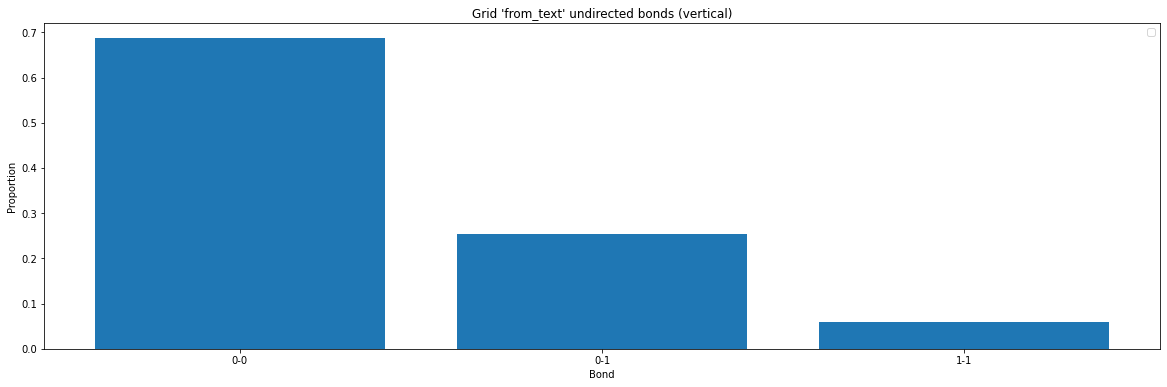

Grid 'from_text' undirected bonds (combined):
{(0, 0): 0.687, (0, 1): 0.254, (1, 1): 0.06}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


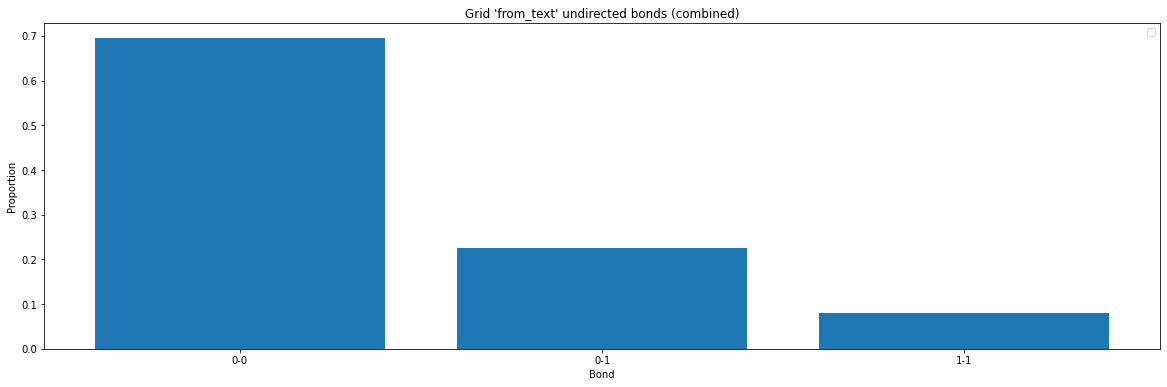

In [5]:
from cactice.plot import plot_undirected_bond_dist

bonds_h, bonds_v = stats.undirected_bond_dist(grids_l)

title = "Overall undirected bonds (horizontal)"
print(f"{title}:")
pprint(bonds_h)
plot_undirected_bond_dist(bonds_h, title)

title = "Overall undirected bonds (vertical)"
print(f"{title}:")
pprint(bonds_v)
plot_undirected_bond_dist(bonds_v, title)

bonds_c = {k: ((v + bonds_v[k]) / 2) for k, v in bonds_h.items()}

title = "Overall undirected bonds (combined)"
print(f"{title}:")
pprint(bonds_v)
plot_undirected_bond_dist(bonds_c, title)

for name, grid in grids.items():
    grid_bonds_h, grid_bonds_v = stats.undirected_bond_dist([grid])

    title = f"Grid '{name}' undirected bonds (horizontal)"
    print(f"{title}:")
    pprint(grid_bonds_h)
    plot_undirected_bond_dist(grid_bonds_h, title)

    title = f"Grid '{name}' undirected bonds (vertical)"
    print(f"{title}:")
    pprint(grid_bonds_v)
    plot_undirected_bond_dist(grid_bonds_v, title)

    grid_bonds_c = {k: ((v + grid_bonds_v[k]) / 2) for k, v in grid_bonds_h.items()}

    title = f"Grid '{name}' undirected bonds (combined)"
    print(f"{title}:")
    pprint(grid_bonds_v)
    plot_undirected_bond_dist(grid_bonds_c, title)

## Imputation & prediction

By default `cactice` interprets empty or zero-valued grid cells as missing values. Several methods for predicting missing cells given a known cell distribution are supported:

- random neighbor selection
- k-nearest neighbors
- bond energy minimization (via Metropolis algorithm)

These strategies can also be used to generate entirely novel grids. They follow the `numpy` and `scipy` conventions in exposing two primary methods, `fit()` and `predict()`.

### Random neighbor selection

The random neighbor selection strategy attempts to locate then select randomly from known neighbors of each unknown cell location: thus an unknown cell's neighbors "vote" to select its own value. If no neighbors are known, the cell's value is randomly selected according to the known class distribution.

A new random neighbor selection model can be created as such:

In [6]:
from cactice.rns import RNS
from cactice.neighbors import Neighbors

rns = RNS(neighbors=Neighbors.CARDINAL, layers=1)

Next, fit the model on grids we've read into `cactice`:

In [7]:
rns.fit(list(grids.values()))

Now impute missing cell locations on the multinomial training grids:

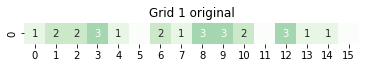

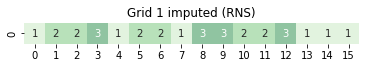

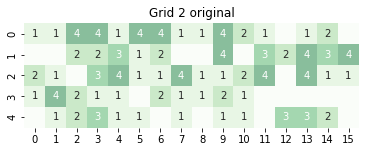

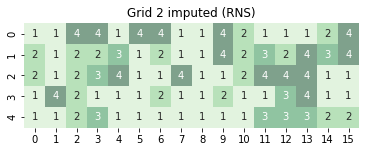

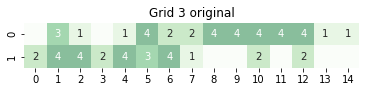

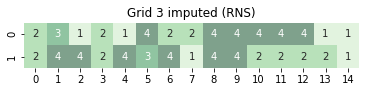

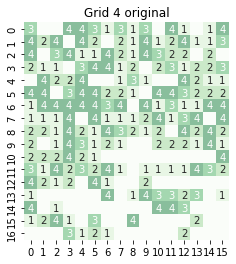

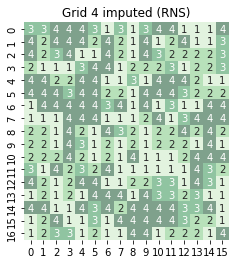

In [8]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    imputed = rns.predict([grid])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(imputed, f"Grid {name} imputed (RNS)")

Random neighbor selection can also be used to predict entirely novel grids, but this is not suggested: it will tend simply to reproduce the training grids' cell class distribution without preserving any spatial information.

For instance:

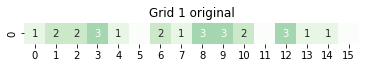

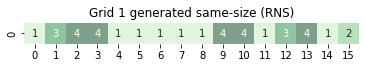

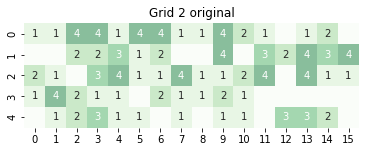

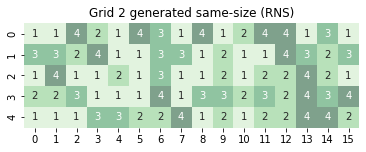

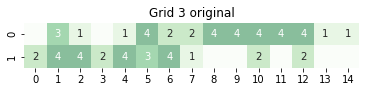

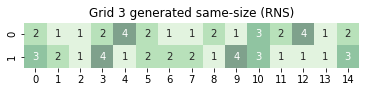

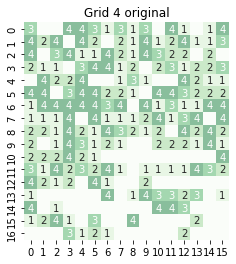

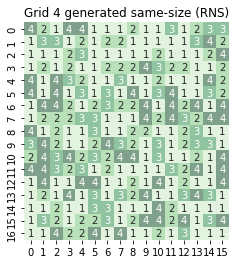

In [9]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    novel = np.zeros_like(grid).astype(int)
    novel = rns.predict([novel])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(novel, f"Grid {name} generated same-size (RNS)")

    # TODO demonstrate that class distribution is roughly equivalent while bond distribution is not?

### K-nearest neighbors

The k-nearest neighbors model attempts to predict cell values based on neighborhoods similar to the location to be predicted. Neighborhood similarity is evaluated by mapping each neighborhood to a fixed-length string, in which each neighboring location corresponds to a particular character, and computing the Hamming distance between strings. The algorithm then ranks neighborhoods according to similarity to the neighborhood of the cell to be predicted, retaining a small subset of the most similar neighborhoods, then selects the most common central cell value from the subset (ties are broken randomly).

In [10]:
from cactice.knn import KNN
from cactice.neighbors import Neighbors

knn = KNN(k=10, neighbors=Neighbors.CARDINAL, layers=1)

Fit the model on the grids we've loaded:

In [11]:
knn.fit(list(grids.values()))

Now impute missing locations on the multinomial training grids:

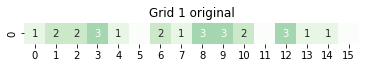

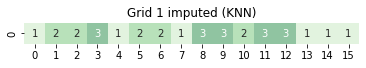

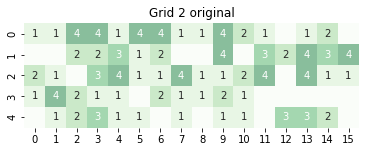

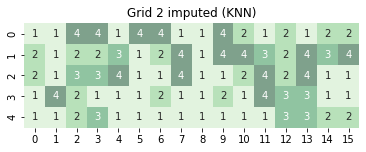

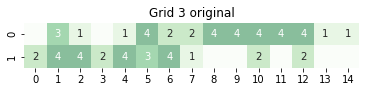

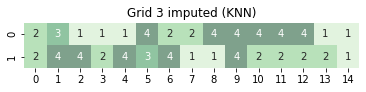

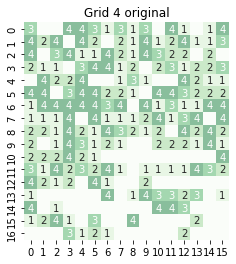

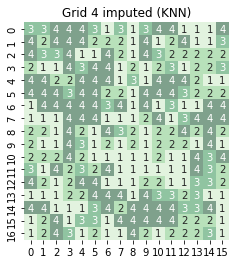

In [12]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    imputed = rns.predict([grid])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(imputed, f"Grid {name} imputed (KNN)")

KNN can also be used to generate entirely novel grids, but this is subject to the same limitation faced by RNS: when a cell has no known neighbors, the cell value is randomly selected according to the known class distribution (preserving no spatial information from the training set).

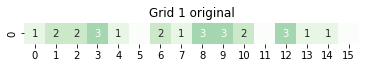

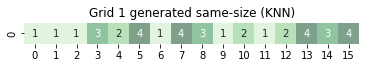

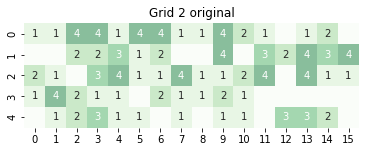

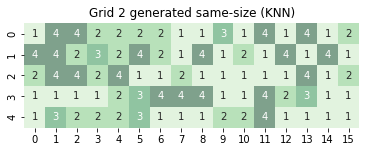

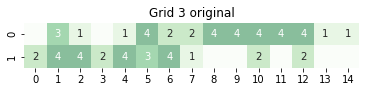

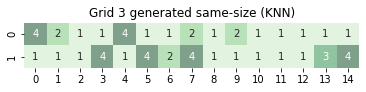

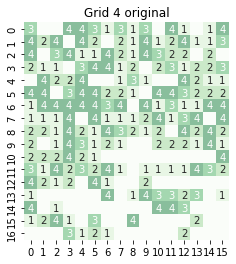

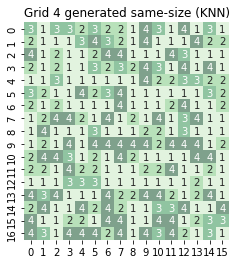

In [13]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    novel = np.zeros_like(grid).astype(int)
    novel = knn.predict([novel])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(novel, f"Grid {name} generated same-size (KNN)")

    # TODO demonstrate that class distribution is roughly equivalent while bond distribution is not?

### Bond energy minimization

The bond energy minimization model takes inspiration from statistical physics, in particular spin lattices and associated Markov random field theory. "Bonds" between adjacent grid cells are assigned an energy proportional to the bond distribution in the training set; i.e., cell pairs rarely found adjacent to one another are associated with higher bond energy than frequent pairs. A Markov chain Monte Carlo method (namely the Metropolis algorithm) is then applied to minimize the total configuration energy (the sum of bond energies over the whole grid).

In [14]:
from cactice.mrf import MRF
from cactice.neighbors import Neighbors

mrf = MRF(neighbors=Neighbors.CARDINAL,
          interaction='proportional',
          J=2.0,
          iterations=50,
          threshold=0.01)

Fit the model:

In [15]:
mrf.fit(list(grids.values()))

Now impute the multinomial grids:

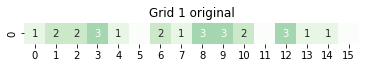

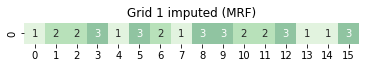

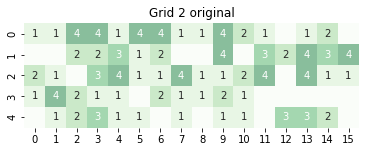

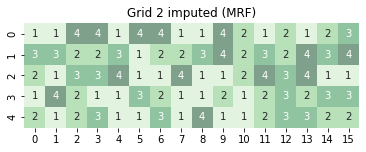

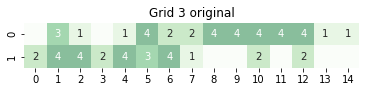

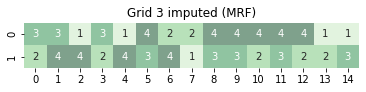

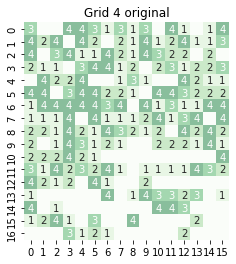

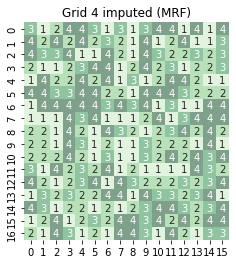

In [16]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    imputed = mrf.predict([grid])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(imputed, f"Grid {name} imputed (MRF)")

Bond energy minimization via MCMC sampling can also be used to generate novel grids. There is a danger, if the Metropolis algorithm is allowed to run too long, however, of overly homogeneous predictions. Since the objective function considers only the overall bond distribution, it will eventually converge to the maximum number possible of the most frequent bonds in the training set. This fails to capture larger spatial structures latent in the training data.

To obtain good results, the number of iterations may need to be tuned proportional to grid size. Note how the largest generated grid is much more plausible than the smallest (which seems much more regular than its real counterpart).

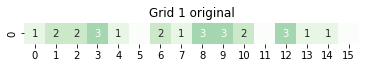

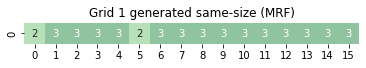

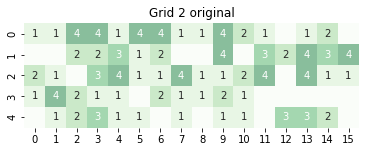

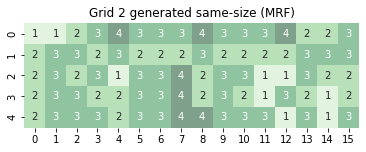

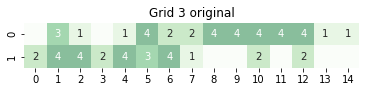

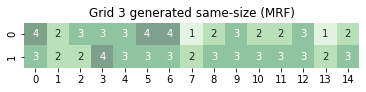

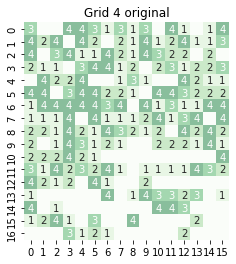

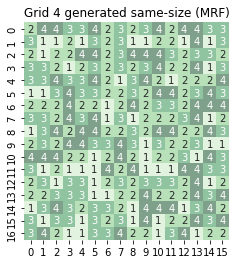

In [17]:
mrf = MRF(neighbors=Neighbors.CARDINAL,
          interaction='proportional',
          J=2.0,
          iterations=50,
          threshold=0.01)

mrf.fit(list(grids.values()))

for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    novel = np.zeros_like(grid).astype(int)
    novel = mrf.predict([novel])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(novel, f"Grid {name} generated same-size (MRF)")

    # TODO demonstrate that both class distribution and bond distribution are similar?
    # this is why MRF is better for imputing sparser data and/or generating it de novo

## Cross-validation & metrics

TODO

## Finding tiles

`cactice` can search grids for "tiles" (contiguous regions) of a particular class. For instance, to find non-empty tiles (in this case consisting of `#` characters) in a binary grid:

In [18]:
from cactice.tiles import find_tiles

tiles = find_tiles(grids['from_text'], target=1)
print("Tiles:")
pprint(tiles)

Tiles:
[[[0, 28], [1, 28], [2, 28], [2, 29], [3, 28]],
 [[1, 2], [1, 3], [1, 4], [2, 3], [3, 3]],
 [[1, 13], [2, 13], [3, 13], [3, 14], [3, 15]],
 [[1, 18], [2, 18], [2, 19], [3, 19], [3, 20]],
 [[1, 24], [2, 23], [2, 24], [2, 25], [3, 24]],
 [[2, 7], [2, 9], [3, 7], [3, 8], [3, 9]],
 [[5, 7], [6, 7], [7, 7], [8, 7], [9, 7]],
 [[5, 10], [6, 10], [7, 10], [8, 10], [8, 11]],
 [[5, 19], [6, 19], [7, 18], [7, 19], [8, 18]],
 [[6, 3], [6, 4], [7, 2], [7, 3], [8, 3]],
 [[6, 14], [6, 15], [6, 15], [7, 14], [7, 15], [8, 14]],
 [[6, 22], [6, 23], [7, 23], [8, 23], [8, 24]]]
